## Color Code Supplemental Example

This notebook serves as a supplement to the **Moveless Example** and requires installation of the `chromobius` package.

While the code is largely similar to the surface code example, this notebook is separated because it requires a different Python environment:

- **Python version:** ≥ 3.10

Please ensure your environment is properly configured before running this notebook.

In [ ]:
!pip install chromobius~=1.0

In [ ]:
import chromobius
import stim
import sinter
from typing import List
import os

def compute_ler_CC(file_name, compiler_mode, inputCircuit=None, ancilla_str="1m"):
    if (compiler_mode == "Moveless"):
        circuit = stim.Circuit.from_file("stim_files_Moveless/color_codes/" + ancilla_str + "/" + file_name)
    elif (compiler_mode == "Baseline"):
        circuit = stim.Circuit.from_file("stim_files_Baseline/color_codes/" + ancilla_str + "/" + file_name)
    elif (compiler_mode == "Test"):
        circuit = inputCircuit
    else:
        print("invalid compiler mode")
        assert(0)
    #print("FILE NAME", file_name)
    #print("Circuit", circuit)
    tasks = [
    sinter.Task(circuit=circuit)]
    #print("got to this point here after reading circuit")
    num_shots = 2_000_000
    collected_stats: List[sinter.TaskStats] = sinter.collect(
        num_workers=6,
        tasks=tasks,
        decoders=['chromobius'],
        max_shots=num_shots,
        max_errors=num_shots/100,
        custom_decoders=chromobius.sinter_decoders()
    )
    errors = collected_stats[0].errors
    #num_logical_errors = count_logical_errors(circuit, num_shots)
    #print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")
    return errors/num_shots

def make_ler_plot_CC(compiler_mode, name, p_range=[0,1], ancilla_str="1m"):
    
    
    if (compiler_mode == "Moveless"):
        arr = os.listdir("stim_files_Moveless/color_codes/" + ancilla_str + "/")
    elif (compiler_mode == "Baseline"):
        arr = os.listdir("stim_files_Baseline/color_codes/"+ ancilla_str + "/")
    else:
        print("Unknown circuit generation mode")
        assert(0)
    #print("arr", arr)
    errors= []
    x_axis = []
    arr = sorted(arr)
    for x in arr:
        if (x.split("p")[0] == name): #I think it wont include full path so this should be good
            right = x.split("p=")[1]
            remainder = right.split("d=")[0]
            p = float(remainder)
            if (p_range[0] <= p and p <= p_range[1]):
                x_axis.append(p)
                print("Circuit is", x)
                ler = compute_ler_CC(x, compiler_mode=compiler_mode, ancilla_str=ancilla_str)
                print("Finished a computation for", p)
                print("Got ler", ler)
                errors.append(ler)
    print("x axis", x_axis)        
    return errors, x_axis

moveless_CC, x = make_ler_plot_CC("Moveless", "37-1-7", [1e-4, 1e-3], "1m")  #1M is chosen for best Moveless performance on linear architectures.
baseline_CC, x_baseline = make_ler_plot_CC("Baseline", "37-1-7", [1e-4, 1e-3], "maxm") #Baseline full ancillary count

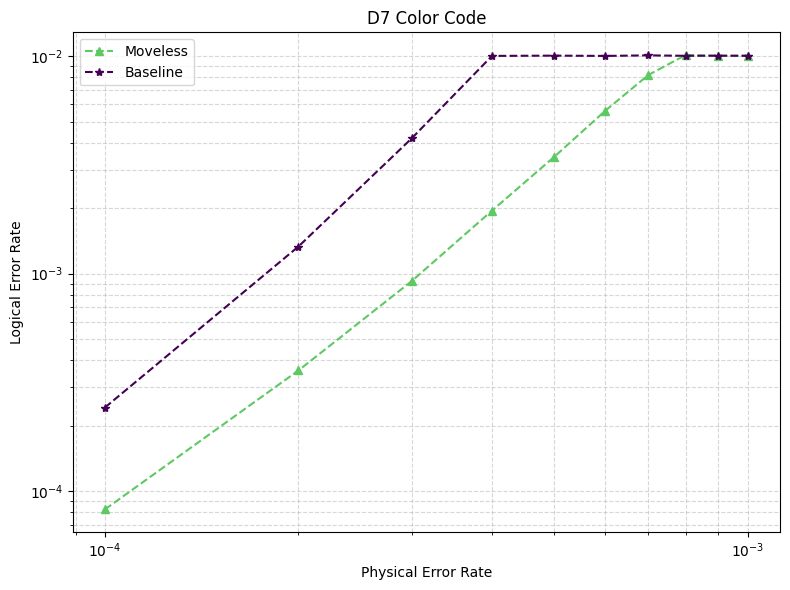

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def plot_LERS(x, moveless, baseline):
    # Get colors from viridis colormap
    colors = plt.get_cmap('viridis')(np.linspace(0, 1, 5))
    color_baseline = colors[0]
    color_moveless = colors[3]

    plt.figure(figsize=(8, 6))
    plt.plot(x, moveless, label='Moveless', marker='^', linestyle='--', linewidth=1.5, color=color_moveless)
    plt.plot(x, baseline, label='Baseline', marker='*', linestyle='--', linewidth=1.5, color=color_baseline)

    plt.xlabel('Physical Error Rate')
    plt.ylabel('Logical Error Rate')
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.title("D7 Color Code")
    plt.legend()
    plt.tight_layout()
    plt.show()


#assert(x == x_baseline)
plot_LERS(x, moveless_CC, baseline_CC)